In [23]:
%run init_notebook.py
from settings import DATA_DIR, GRAPHS_WEB_DIR, PROJECT_ROOT

In [24]:
import string
def clean_punctuation(list_of_tokens: list):
    translate_table = dict((ord(char), None) for char in string.punctuation)
    lst_cleaned = [s.translate(translate_table) for s in list_of_tokens]
    return [s for s in lst_cleaned if s != '']

In [25]:
GRAPHS_WEB_DIR = os.path.join(PROJECT_ROOT, 'nlp_code', 'latex', 'graphs')

In [5]:
import os

from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

from datetime import datetime

from itertools import chain
import spacy
import nltk
import matplotlib.pyplot as plt

from statsmodels.regression.linear_model import OLS

NLP = spacy.load("en_core_web_lg")

In [7]:
from nlp_code.ecb_pc import vec_similarity, clean_punctuation, get_pair_lag

In [8]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

stemmer = PorterStemmer()
nltk_stp_words = stopwords.words('english')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

# stop words

In [10]:
stp_words_remove = ['call', 'amount', 'against', 'above', 'up', 'down', 'serious', 'quite']
for i in stp_words_remove:
    NLP.Defaults.stop_words.remove(i)

nltk_stp_words = [i for i in nltk_stp_words if i not in stp_words_remove]

# pessimism

In [11]:
pessimism = pd.read_csv(os.path.join(DATA_DIR, 'lou_mcD_dict.csv'))

n_words = pd.get_dummies(pessimism.set_index('Word')['Negative']).iloc[:, 2:].sum(axis=1)
n_words = [i.lower() for i in n_words[n_words > 0].index]

p_words = pd.get_dummies(pessimism.set_index('Word')['Positive']).iloc[:, 2:].sum(axis=1)
p_words = [i.lower() for i in p_words[p_words > 0].index]

dict_pessimism = {'positive': p_words, 'negative': n_words}

# scrape data

In [12]:
url_base = "https://www.ecb.europa.eu/"
pc_links = pd.read_excel(os.path.join(DATA_DIR, 'pc_link.xlsx'))
speeches, soups = {}, {}

for idx, url_ext in enumerate(pc_links['link']):
    soup = BeautifulSoup(
        requests.get(url_base+url_ext).content, 
        'html.parser'
        )

    soups[idx] = {'soup': soup, 'url': url_base + url_ext}

# extract information from html

In [17]:
urls_excluded = [
    'https://www.ecb.europa.eu//press/pressconf/2003/html/is030508_1.en.html',
    'https://www.ecb.europa.eu//press/pressconf/visual-mps/html/index.en.html'
    ]

for idx, _dict in list(soups.items()):

    soup, url = _dict['soup'], _dict['url']
    if url in urls_excluded:
        continue

    # date    
    date = soup.head.find('meta', attrs={'property': 'article:published_time'}).attrs['content']
    date = datetime(*[int(i) for i in date.split('-')])
    assert type(date) == datetime

    # title
    title = soup.head.title.text
    assert len(title) > 1

    # header
    header = soup.body.find_all('h2', attrs={'class': 'ecb-pressContentSubtitle'})
    assert len(header) == 1, f"Other than one header {header}"
    header = header[0].text

    ## speech text
    
    # try layout 1: text is in div section with h2 headline
    speech = soup.body.find_all('div', attrs={'class': 'section'})
    h2s = [False if i.find('h2', attrs={'class': 'ecb-pressContentSubtitle'}) is None else True for i in speech]

    if sum(h2s) == 1:
        speech = speech[h2s.index(True)].find_all('p')
    else:
        speech = []

    # try layout 2: text is in div section proceeded by QA link
    if len(speech) == 0:
        speech = soup.body.find_all('div', attrs={'class': 'section'})
        filt = [False if i.find('a', attrs={'href': '#qa'}) is None else True for i in speech]

        if sum(filt) == 1:
            speech = speech[filt.index(True)].find_all('p')
        else:
            speech = []

    # try layout 3: text ends on "We are now at your disposal, should you have any questions"
    if len(speech) == 0:
        speech = soup.body.find_all('div', attrs={'class': 'section'})
        ps = [i.find_all('p') for i in speech]
        filt = ['disposal' in p[-1].text.lower() and 'question' in p[-1].text.lower() if len(p) > 0 else False for p in ps]
        assert sum(filt) == 1
        speech = speech[filt.index(True)]

    # Specific exception
    if url == 'https://www.ecb.europa.eu//press/pressconf/2000/html/is001005.en.html':
        speech = soup.body.find_all('div', attrs={'class': 'section'})
        speech = speech[3]


    assert len(speech) > 0, "No speech text found"
    speech = ' '.join([*chain([i.text for i in speech])]).replace('  ', ' ')

    # spacy
    doc = NLP(speech)
    tokens = [i for i in [*doc] if not i.is_stop and not i.is_punct]

    # bigrams spacy
    bigrams = [(tokens[i-1].lemma_, tokens[i].lemma_) for i in range(1, len(tokens))]

    # bigrams nltk
    tokens = [t.text for t in doc if t.text not in nltk_stp_words]
    tokens = clean_punctuation(tokens)
    bigrams_nltk = [(tokens[i-1].lower(), tokens[i].lower()) for i in range(1, len(tokens))]

    # pessimism
    n = [True if i.lower() in dict_pessimism['negative'] else False for i in tokens]
    p = [True if i.lower() in dict_pessimism['positive'] else False for i in tokens]
    score_pessimism = (sum(n) - sum(p)) / len(tokens)

    # embeds
    embed_ajd = np.mean(np.array([i.vector for i in doc if i.pos_ == 'ADJ' and i.has_vector]), axis=0)
    embed_propn = np.mean(np.array([i.vector for i in doc if i.pos_ == 'PROPN' and i.has_vector]), axis=0)
    
    speeches[idx] = {
        'date': date,
        'url': url,
        'title': title,
        'header': header,
        'text': speech,
        'doc': doc,
        'bigrams': bigrams,
        'bigrams_nltk': bigrams_nltk,
        'embed_ajd': embed_ajd,
        'emebd_propn': embed_propn,
        'pessimism': score_pessimism,
    }


In [110]:
bigrams = get_pair_lag(speeches, 'bigrams')
ajds = get_pair_lag(speeches, 'embed_ajd')
propns = get_pair_lag(speeches, 'emebd_propn')
b_nltk = get_pair_lag(speeches, 'bigrams_nltk')

similarity_bigram = [len(set(i[0]).intersection(i[1])) / len(set(i[0]).union(i[1])) for i in bigrams]
similarity_bigram_nltk = [len(set(i[0]).intersection(i[1])) / len(set(i[0]).union(i[1])) for i in b_nltk]
similarity_ajds = [vec_similarity(i[0], i[1]) for i in ajds]
similarity_propns = [vec_similarity(i[0], i[1]) for i in propns]

pessim = [i['pessimism'] for i in speeches.values()]

similarity = pd.DataFrame(np.array(
    [similarity_ajds, similarity_bigram, similarity_propns, similarity_bigram_nltk]
).transpose(),
                          index=[i['date'] for i in speeches.values()][1:],
                          columns=['bigram', 'b_nltk', 'ajd', 'propns'])
similarity['pessimism'] = pessim[1:]
similarity.sort_index(inplace=True)

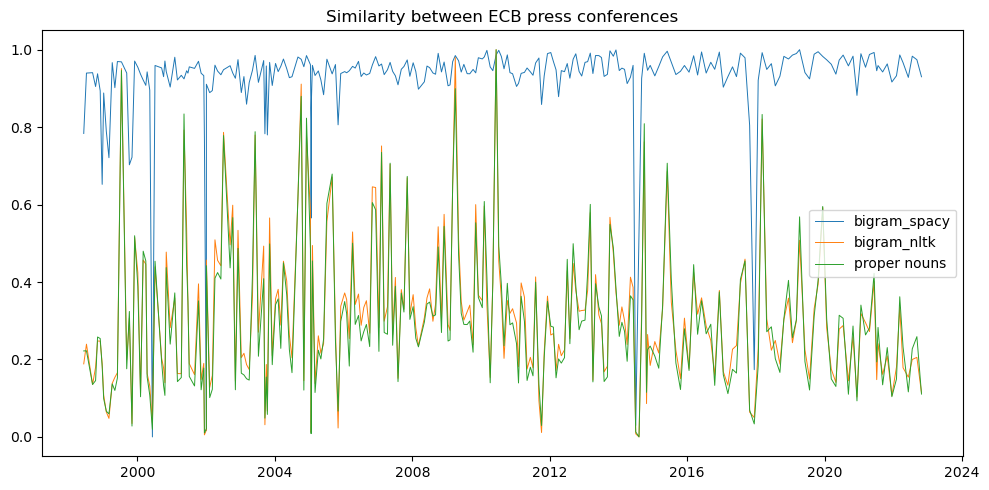

In [80]:
similarity_plot = similarity.apply(lambda x: (x - x.min()) / (x.max() - x.min())).copy()
fig = plt.figure(figsize=(10, 5))
plt.plot(similarity_plot.drop(['pessimism', 'ajd'], axis=1), linewidth=.7)
plt.title('Similarity between ECB press conferences', size=12)
plt.legend(['bigram_spacy', 'bigram_nltk', 'proper nouns'])
plt.tight_layout()
fig.savefig(os.path.join(GRAPHS_WEB_DIR, 'similarity.png'))

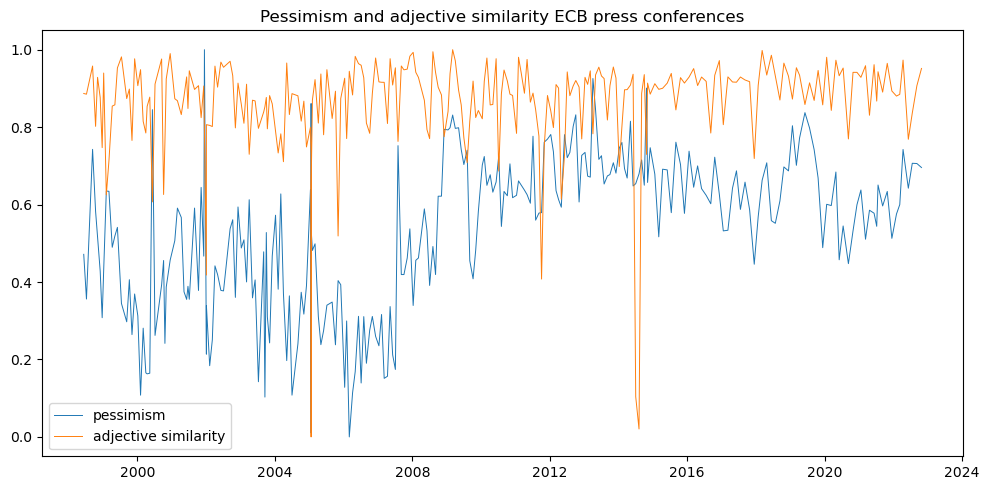

In [81]:
fig = plt.figure(figsize=(10, 5))
plt.plot(similarity_plot['pessimism'], linewidth=.7)
plt.plot(similarity_plot['ajd'], linewidth=.7)
plt.title('Pessimism and adjective similarity ECB press conferences', size=12)
plt.legend(['pessimism', 'adjective similarity'])
plt.tight_layout()
fig.savefig(os.path.join(GRAPHS_WEB_DIR, 'pessimism.png'))

# controls and EuroStoxx 50

In [111]:
controls = pd.read_csv(os.path.join(DATA_DIR, 'controls.csv'))
controls['date'] = controls['Unnamed: 0'].apply(lambda x: datetime(int(x.split('-')[0]), int(x.split('-')[1]), int(x.split('-')[2])))
controls.drop('Unnamed: 0', axis=1, inplace=True)
controls.set_index('date', inplace=True)
controls['estoxx_50_level'] = controls['estoxx_50']

In [112]:
controls['estoxx_50'] = np.log(controls['estoxx_50'].dropna()).diff()

In [113]:
controls = controls.join(controls['estoxx_50'].dropna().rolling(201).mean().shift(50).rename('estoxx_50_rol'))
controls['estoxx_50_exret'] = controls['estoxx_50'] - controls['estoxx_50_rol']
controls['estoxx_50_abret'] = controls['estoxx_50_exret'].rolling(5).sum() + \
                                controls['estoxx_50_exret'].rolling(5).sum().shift(5) - controls['estoxx_50_exret']
controls['estoxx_50_abret_abs'] = controls.estoxx_50_abret.abs()

In [114]:
similarity['ymonth'] = [f'{i.year}_{i.month}' for i in similarity.index]
controls['ymonth'] = [f'{i.year}_{i.month}' for i in controls.index]

In [115]:
similarity.index.name = 'dates'
controls.index.name = 'datec'

In [116]:
similarity = similarity.reset_index().set_index('ymonth')
controls = controls.reset_index().set_index('ymonth')

In [143]:
data1 = controls[['estoxx_50_abret', 'estoxx_50_abret_abs']].join(similarity[['pessimism', 'b_nltk']]).dropna()
data1 = controls[['estoxx_50_abret', 'estoxx_50_abret_abs']].join(similarity[['pessimism', 'b_nltk']]).dropna()
data1['pessimism_b_nltk'] = data1.pessimism * data1.b_nltk

In [162]:
data2 = controls.join(similarity, how='outer').copy().dropna()
data2 = data2[['cpi_cyc', 'gdp_cyc', 'estoxx_50_abret_abs', *similarity.columns]].set_index('dates')

# Reg

In [145]:
ols1 = OLS(data1.estoxx_50_abret_abs, data1.pessimism).fit()
print(ols1.summary())

                                 OLS Regression Results                                 
Dep. Variable:     estoxx_50_abret_abs   R-squared (uncentered):                   0.439
Model:                             OLS   Adj. R-squared (uncentered):              0.439
Method:                  Least Squares   F-statistic:                              2212.
Date:                 Fri, 24 Nov 2023   Prob (F-statistic):                        0.00
Time:                         19:04:05   Log-Likelihood:                          5642.3
No. Observations:                 2822   AIC:                                 -1.128e+04
Df Residuals:                     2821   BIC:                                 -1.128e+04
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [146]:
ols2 = OLS(data1.estoxx_50_abret_abs, data1[['pessimism_b_nltk']]).fit()
print(ols2.summary())

                                 OLS Regression Results                                 
Dep. Variable:     estoxx_50_abret_abs   R-squared (uncentered):                   0.367
Model:                             OLS   Adj. R-squared (uncentered):              0.367
Method:                  Least Squares   F-statistic:                              1638.
Date:                 Fri, 24 Nov 2023   Prob (F-statistic):                   8.00e-283
Time:                         19:04:08   Log-Likelihood:                          5471.6
No. Observations:                 2822   AIC:                                 -1.094e+04
Df Residuals:                     2821   BIC:                                 -1.094e+04
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [164]:
ols2 = OLS(data2.estoxx_50_abret_abs, data2.drop('estoxx_50_abret_abs', axis=1)).fit()
print(ols2.summary())

                                 OLS Regression Results                                 
Dep. Variable:     estoxx_50_abret_abs   R-squared (uncentered):                   0.644
Model:                             OLS   Adj. R-squared (uncentered):              0.555
Method:                  Least Squares   F-statistic:                              7.226
Date:                 Fri, 24 Nov 2023   Prob (F-statistic):                    5.73e-05
Time:                         19:06:01   Log-Likelihood:                          83.015
No. Observations:                   35   AIC:                                     -152.0
Df Residuals:                       28   BIC:                                     -141.1
Df Model:                            7                                                  
Covariance Type:             nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

<Axes: xlabel='dates'>

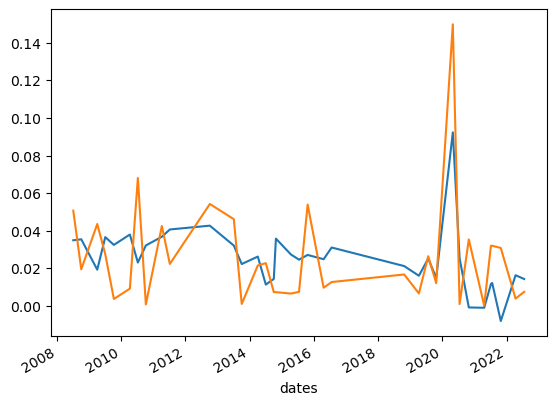

In [166]:
ols2.fittedvalues.plot()
data2.estoxx_50_abret_abs.plot()